* used the 2018 Movie Lens data set from http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html
* feature engineered genres by performing one hot encoding
* utilized random forest to confirm that this model would be a poor predictor when compared to recommender models

In [1]:
# import dependencies
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import movies
movies = pd.read_csv("../ml-latest-small/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# import ratings
ratings = pd.read_csv("../ml-latest-small/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
# merge movies and ratings
df = pd.merge(ratings, movies, on="movieId")
df.sort_values("userId").head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
12117,1,2389,2.0,964983094,Psycho (1998),Crime|Horror|Thriller
12126,1,2395,5.0,964981093,Rushmore (1998),Comedy|Drama
12182,1,2406,4.0,964982310,Romancing the Stone (1984),Action|Adventure|Comedy|Romance
776,1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller


In [5]:
# parse year from title
df['year'] = df['title'].str.extract('.*\((.*)\).*')
df.head()

,userId,movieId,rating,timestamp,title,genres,year
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995


In [6]:
# check for null values
df.isna().sum()

userId        0
movieId       0
rating        0
timestamp     0
title         0
genres        0
year         17
dtype: int64

In [7]:
# clean null and incorrectly formatted years
df = df.replace(to_replace='2006–2007', value='2007')
df = df.fillna(0)
df.head()

,userId,movieId,rating,timestamp,title,genres,year
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995


In [8]:
# used one hot encoding to transform genres into features
genres = pd.get_dummies(df.genres.str.split('|',expand=True).stack()).sum(level=0)
genres.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [9]:
genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 20 columns):
(no genres listed)    100836 non-null uint8
Action                100836 non-null uint8
Adventure             100836 non-null uint8
Animation             100836 non-null uint8
Children              100836 non-null uint8
Comedy                100836 non-null uint8
Crime                 100836 non-null uint8
Documentary           100836 non-null uint8
Drama                 100836 non-null uint8
Fantasy               100836 non-null uint8
Film-Noir             100836 non-null uint8
Horror                100836 non-null uint8
IMAX                  100836 non-null uint8
Musical               100836 non-null uint8
Mystery               100836 non-null uint8
Romance               100836 non-null uint8
Sci-Fi                100836 non-null uint8
Thriller              100836 non-null uint8
War                   100836 non-null uint8
Western               100836 non-null uint8
dtypes: u

In [10]:
# merge genres back to the original df
df = pd.concat([df,genres], axis=1)

In [11]:
# removing original genres column since we now have the one hot encoded version
# removing title since we already parsed the year
# removing timestamp since we are not interested in making this a feature
data = df.drop(['genres', 'title', 'timestamp'],axis=1, inplace=True)
data = df.apply(pd.to_numeric) 
data.head()

,userId,movieId,rating,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,1995,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,5,1,4.0,1995,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,7,1,4.5,1995,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,15,1,2.5,1995,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,17,1,4.5,1995,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# set rating to what we are trying to predict
target = df["rating"].astype(int)

In [13]:
# removing ratings to create our x values
data.drop(["rating"],axis=1, inplace=True)

In [14]:
# data = data
feature_names = data.columns
data.head()

,userId,movieId,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,5,1,1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,7,1,1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,15,1,1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,17,1,1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# convert to int
# df['rating'] = df['rating'].astype(int) 
# target = df["rating"]

In [16]:
# df['userId'] = df['userId'].astype(int) 
# df['movieId'] = df['movieId'].astype(int) 
# df['year'] = df['year'].astype(int) 

In [17]:
# data = df[["userId", "movieId", "year", "genresVect"]]
# data = df[["genresVect"]]
feature_names = data.columns
# data.head()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [19]:
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.3367448133603078

In [20]:
importances = rf.feature_importances_
importances

array([6.54470763e-01, 1.65844911e-01, 8.66551880e-02, 1.24402000e-04,
       7.89213629e-03, 7.35675384e-03, 3.31813928e-03, 3.92373747e-03,
       6.36528895e-03, 5.92143343e-03, 1.24171566e-03, 6.13929221e-03,
       6.53682980e-03, 9.54529161e-04, 4.23285137e-03, 2.13550400e-03,
       2.99896068e-03, 4.78856152e-03, 8.16146048e-03, 7.52413501e-03,
       7.92577254e-03, 3.13786652e-03, 2.34976736e-03])

In [21]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

[(0.6544707630370193, 'userId'),
 (0.1658449113809424, 'movieId'),
 (0.08665518801007563, 'year'),
 (0.008161460477190664, 'Romance'),
 (0.007925772541133337, 'Thriller'),
 (0.0078921362943831, 'Action'),
 (0.007524135010037867, 'Sci-Fi'),
 (0.007356753835995131, 'Adventure'),
 (0.006536829803716083, 'Fantasy'),
 (0.006365288948431519, 'Comedy'),
 (0.006139292207861802, 'Drama'),
 (0.005921433428467048, 'Crime'),
 (0.004788561519133641, 'Mystery'),
 (0.00423285137400982, 'Horror'),
 (0.003923737473973146, 'Children'),
 (0.0033181392779129794, 'Animation'),
 (0.003137866523172838, 'War'),
 (0.0029989606756987306, 'Musical'),
 (0.0023497673587891104, 'Western'),
 (0.002135503999057147, 'IMAX'),
 (0.0012417156620852133, 'Documentary'),
 (0.0009545291609058873, 'Film-Noir'),
 (0.00012440200000752482, '(no genres listed)')]

In [22]:
sns.set(rc={'figure.figsize':(6,10)})

No handles with labels found to put in legend.


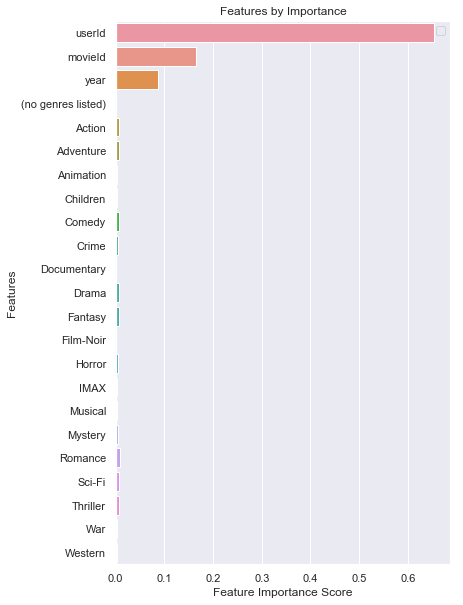

In [23]:
sns.barplot(x=importances, y=feature_names)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Features by Importance")
plt.legend()
plt.savefig("images/RF2018OHE.png")
plt.show()